In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def block(cons, bot, top):
    faces = []
    for con in cons:
        cp = list(con)
        cp += [cp[0]]
        for i in range(len(cp)-1):
            p1 = cp[i][0]
            p2 = cp[i+1][0]
            q1 = (p1[0], p1[1], bot)
            q2 = (p2[0], p2[1], bot)
            q3 = (p2[0], p2[1], top)
            q4 = (p1[0], p1[1], top)
            faces += [[q1, q2, q3, q4]]
    return faces

def bound(cons, h):
    faces = []
    for con in cons:
        sur = []
        for p in con:
            sur += [(p[0][0], p[0][1], h)]
        faces += [sur]
    return faces

In [3]:
yar1, door2, yar3, wind2, yar2, yar4, zone, flor = np.load('./Mask/array.npy')

In [4]:
import vtkmodules.all as vtk
import vtkmodules.util.numpy_support as vtk_np

def show_image(image, title="Image", l=False):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    if not l:
        plt.axis('off')
    plt.show()
    
def create_wall(points):
    # Создание массива точек
    points_array = vtk.vtkPoints()
    for x, y, z in points:
        points_array.InsertNextPoint(x, -y, z)

    # Создание полигональной поверхности
    polygon = vtk.vtkPolygon()
    polygon.GetPointIds().SetNumberOfIds(len(points))
    for i in range(len(points)):
        polygon.GetPointIds().SetId(i, i)

    # Создание ячейки и добавление полигона в нее
    cells = vtk.vtkCellArray()
    cells.InsertNextCell(polygon)

    # Создание полигонального объекта
    poly_data = vtk.vtkPolyData()
    poly_data.SetPoints(points_array)
    poly_data.SetPolys(cells)

    # Создание маппера и актера для визуализации
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(poly_data)

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(0.5, 0.5, 0.5)  # Цвет в формате RGB

    return actor

def get_mask(points, camera_position=(10, 10, 10), focal_point=(0, 0, 0), view_up=(0, 1, 0), view_angle=30.0):
    renderer = vtk.vtkRenderer()
    renderer.SetBackground(1, 1, 1)  # Белый фон

    for i in points:
        actor = create_wall(i)
        renderer.AddActor(actor)

    render_window = vtk.vtkRenderWindow()
    render_window.SetOffScreenRendering(1)  # Отключить отображение окна
    render_window.SetSize(1024, 1024)
    render_window.AddRenderer(renderer)

    # Настройка камеры
    camera = vtk.vtkCamera()
    camera.SetPosition(camera_position)
    camera.SetFocalPoint(focal_point)
    camera.SetViewUp(view_up)
    camera.SetViewAngle(view_angle)
    renderer.SetActiveCamera(camera)
    renderer.ResetCameraClippingRange()

    render_window.Render()

    # Извлечение данных из буфера глубины
    window_size = render_window.GetSize()
    z_buffer = vtk.vtkFloatArray()
    render_window.GetZbufferData(0, 0, window_size[0] - 1, window_size[1] - 1, z_buffer)

    # Преобразование в numpy массив
    z_buffer_np = vtk_np.vtk_to_numpy(z_buffer)
    z_buffer_np = z_buffer_np.reshape(window_size[1], window_size[0])

    # Инвертирование буфера глубины (чтобы ближние значения были больше)
    z_buffer_np = 1 - z_buffer_np

    return z_buffer_np

def plot_3d_wall(points):
    renderer = vtk.vtkRenderer()
    renderer.SetBackground(1, 1, 1)
    
    for i in points:
        actor = create_wall(i)
        renderer.AddActor(actor)

    render_window = vtk.vtkRenderWindow()
    render_window.SetWindowName("3D Модель стены")
    render_window.SetSize(800, 600)
    render_window.AddRenderer(renderer)

    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    render_window.Render()
    render_window_interactor.Start()

In [5]:
hi = int(120)
po = int(hi*0.28)
do = int(hi*0.79)
wi = int(hi*0.86)

In [6]:
w1 = block(cv2.findContours(yar1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], 0, po)
w2 = block(cv2.findContours(yar2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], po, do)
w3 = block(cv2.findContours(yar3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], do, wi)
w4 = block(cv2.findContours(yar4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], wi, hi)
fl = bound(cv2.findContours(flor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], 0)
ci = bound(cv2.findContours(flor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], hi)
dv = bound(cv2.findContours(door2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], do)
okno = cv2.findContours(wind2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
pk = bound(okno, po)
pw = bound(okno, wi)
mesh = w1+w2+w3+w4+fl+dv+pk+pw+ci

In [8]:
plot_3d_wall(mesh)

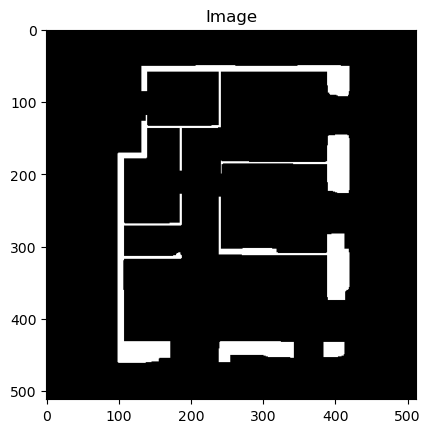

In [82]:
show_image(yar2, l=True)

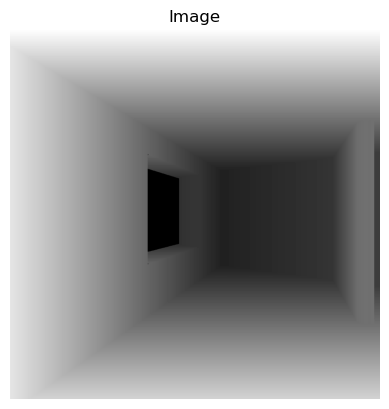

In [97]:
camera_position = (330, -350, 65)
focal_point = (200, -420, 65)
view_up = (0, 0, 1)

dm = get_mask(mesh, camera_position, focal_point, view_up, 90)
show_image(dm[::-1])
dm -= dm.min()
dm /= dm.max()
img = Image.fromarray((dm[::-1]*255).astype(np.uint8))
img.save('./Image generation/1.jpg')

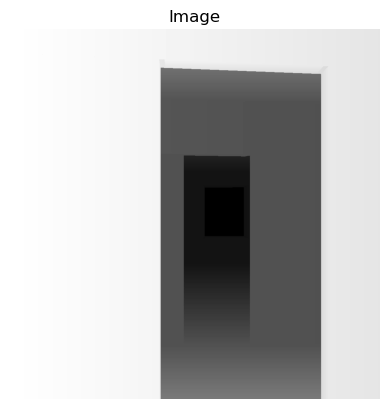

In [98]:
camera_position = (150, -200, 65)
focal_point = (350, -210, 65)
view_up = (0, 0, 1)

dm = get_mask(mesh, camera_position, focal_point, view_up, 90)
show_image(dm[::-1])
dm -= dm.min()
dm /= dm.max()
img = Image.fromarray((dm[::-1]*255).astype(np.uint8))
img.save('./Image generation/2.jpg')

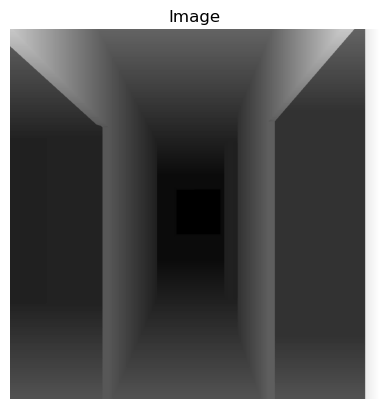

In [99]:
camera_position = (210, -170, 65)
focal_point = (210, -400, 65)
view_up = (0, 0, 1)

dm = get_mask(mesh, camera_position, focal_point, view_up, 90)
show_image(dm[::-1])
dm -= dm.min()
dm /= dm.max()
img = Image.fromarray((dm[::-1]*255).astype(np.uint8))
img.save('./Image generation/3.jpg')

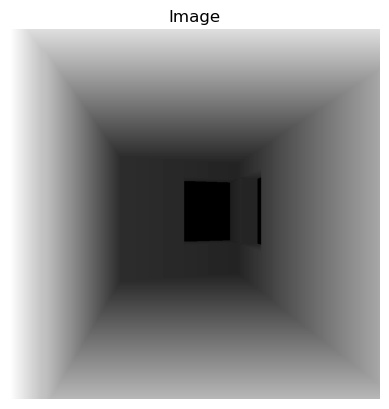

In [100]:
camera_position = (200, -350, 65)
focal_point = (360, -380, 65)
view_up = (0, 0, 1)

dm = get_mask(mesh, camera_position, focal_point, view_up, 90)
show_image(dm[::-1])
dm -= dm.min()
dm /= dm.max()
img = Image.fromarray((dm[::-1]*255).astype(np.uint8))
img.save('./Image generation/4.jpg')